## **Potato Disease Classification**


**Import** Libraries

In [ ]:
import os, shutil, glob, random, zipfile, io, math, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import files

print(tf.__version__)

2.19.0


 **Mount** **Google** **Drive**


Mount your Google Drive so you can read/write datasets and models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Project** **Constants**

Set global constants: IMAGE_SIZE, BATCH_SIZE, EPOCHS, and key paths.

In [ ]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

- **ZIP_PATH** → Path to the downloaded dataset ZIP file in Google Drive.
- **EXTRACT_DIR** → Location where the dataset will be extracted in Colab.
- **PLANTVILLAGE_DIR** → Path to the extracted *PlantVillage* dataset folder.
- **MERGED_DIR** → Folder where all potato images will be merged into class-specific subfolders.
- **BATCH_SIZE** → Number of images processed per batch during training.
- **IMAGE_SIZE** → The height and width (in pixels) to which all images will be resized.
- **CHANNELS** → Number of color channels (3 for RGB).
- **EPOCHS** → Number of times the model will iterate over the entire training dataset.
- **VAL_SPLIT / TEST_SPLIT / TRAIN_SPLIT** → Ratios for splitting the dataset into training, validation, and testing sets.

In [ ]:

ZIP_PATH = "/content/drive/MyDrive/Potato Disease/archive (2).zip"  # <- change if needed
EXTRACT_DIR = "/content/dataset"
PLANTVILLAGE_DIR = os.path.join(EXTRACT_DIR, "PlantVillage")
MERGED_DIR = "/content/dataset/All_Potato_Images"   # parent folder with subfolders per class

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
TRAIN_SPLIT = 1.0 - VAL_SPLIT - TEST_SPLIT

1. **Remove any existing `/content/dataset` folder**  
   This ensures we start fresh and avoid conflicts from previous extractions.

2. **Create a clean dataset directory**  
   We make sure `/content/dataset` exists before extraction.

3. **Unzip the dataset**  
   The dataset ZIP file from `ZIP_PATH` is extracted into the `EXTRACT_DIR` location.

4. **Confirm extraction**  
   A message is printed to verify that the dataset has been successfully extracted.

In [ ]:
!rm -rf /content/dataset
!mkdir -p /content/dataset
!unzip -q "{ZIP_PATH}" -d "{EXTRACT_DIR}"
print("Extracted to:", EXTRACT_DIR)

Extracted to: /content/dataset


**Keep** **Only** **Potato** **Classes**

After extracting the **PlantVillage** dataset, it usually contains images of many plant species.  
Since this project focuses only on **potato leaf diseases**, we remove all non-potato folders.

**What this code does:**
1. Checks if the `PLANTVILLAGE_DIR` exists.
2. Loops through all subfolders inside the dataset directory.
3. Deletes any folder that **does not start with `"Potato"`**.
4. Prints the remaining folders to verify that only potato-related classes are kept.

**Example:** After running this, you should see only  
`Potato___Early_blight`, `Potato___Late_blight`, and `Potato___healthy

In [ ]:
if os.path.exists(PLANTVILLAGE_DIR):
    for folder in os.listdir(PLANTVILLAGE_DIR):
        if not folder.startswith("Potato"):
            shutil.rmtree(os.path.join(PLANTVILLAGE_DIR, folder), ignore_errors=True)
print("Remaining:", os.listdir(PLANTVILLAGE_DIR))

Remaining: ['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']


**List** **Remaining** **Folders**

In [ ]:
print("Folders in PlantVillage:")
for f in sorted(os.listdir(PLANTVILLAGE_DIR)):
    print(" -", f)

Folders in PlantVillage:
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy


**Merge** **All** **Potato** **Images** **into** **a** **Single** **Dataset** Folder

Combine all potato disease class folders into one **parent folder** (`MERGED_DIR`)  
while keeping **separate subfolders** for each class.

**What this code does:**
1. Creates the merged dataset directory (`MERGED_DIR`) if it doesn’t exist.
2. Detects all class folders in `PLANTVILLAGE_DIR` whose names start with `"Potato"`.
3. For each class:
   - Creates a corresponding subfolder inside `MERGED_DIR`.
   - Copies all images from the original folder into this new folder.
   - If a filename already exists, renames it with a suffix (`_1`, `_2`, etc.) to avoid overwriting.
4. Prints the detected class names for confirmation.


In [ ]:
os.makedirs(MERGED_DIR, exist_ok=True)

# detect all class folders that start with "Potato"
detected_classes = [f for f in os.listdir(PLANTVILLAGE_DIR)
                    if f.startswith("Potato") and os.path.isdir(os.path.join(PLANTVILLAGE_DIR, f))]

for cls in detected_classes:
    src = os.path.join(PLANTVILLAGE_DIR, cls)
    dst = os.path.join(MERGED_DIR, cls)
    os.makedirs(dst, exist_ok=True)
    for fname in os.listdir(src):
        s = os.path.join(src, fname)
        d = os.path.join(dst, fname)
        if os.path.isfile(s):
            # avoid overwrite collisions
            if os.path.exists(d):
                base, ext = os.path.splitext(fname)
                i = 1
                while os.path.exists(d):
                    d = os.path.join(dst, f"{base}_{i}{ext}")
                    i += 1
            shutil.copy2(s, d)

print("✅ Merged classes:", detected_classes)

✅ Merged classes: ['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']


**Count** **Images** **per** **Class**

**Goal:**  
Verify that our merged dataset contains the expected number of images for each potato class.

**What this code does:**
1. Defines a helper function `count_images_by_class(root)`:
   - Loops through each subfolder (class) inside the given `root` directory.
   - Counts the number of files with image extensions (`.png`, `.jpg`, `.jpeg`, `.bmp`, `.gif`).
2. Calls the function on `MERGED_DIR` (our merged dataset folder).
3. Displays a dictionary with **class names** as keys and **image counts** as values.

**Why?**  
This is a quick quality check to ensure:
- All classes are present.
- Images were copied successfully.
- No class folder is empty.

In [ ]:
def count_images_by_class(root):
    counts = {}
    for cls in sorted(os.listdir(root)):
        cpath = os.path.join(root, cls)
        if os.path.isdir(cpath):
            counts[cls] = sum([1 for p in os.listdir(cpath)
                               if p.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))])
    return counts

counts = count_images_by_class(MERGED_DIR)
counts

{'Potato___Early_blight': 1000,
 'Potato___Late_blight': 1000,
 'Potato___healthy': 152}

**Visualize** **Image** **Distribution** **per** **Class**

**Goal:**  
Create a bar chart showing how many images are available in each potato class.

**What this code does:**
1. Sets the figure size to **7×4 inches** for readability.
2. Plots a bar chart:
   - **X-axis:** Class names (`Potato___Early_blight`, `Potato___Late_blight`, `Potato___healthy`).
   - **Y-axis:** Number of images in each class.
3. Rotates X-axis labels slightly for better readability.
4. Adds a descriptive title: *"Images per class"*.
5. Uses `tight_layout()` to avoid text overlap.
6. Displays the chart.

💡 **Why?**  
Before training, it’s good practice to:
- Check for **class imbalance**.
- Identify if some classes have significantly fewer images, which could bias the model.

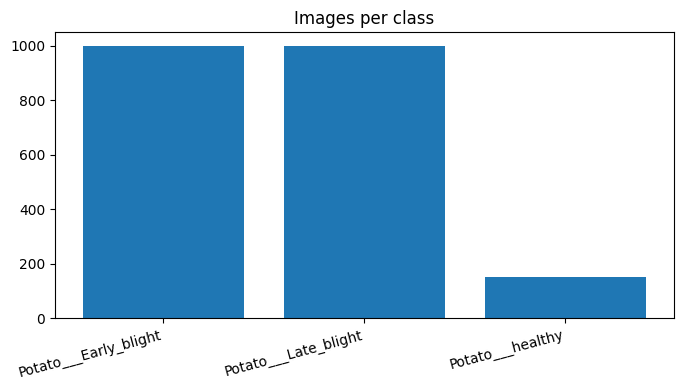

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(range(len(counts)), list(counts.values()))
plt.xticks(range(len(counts)), list(counts.keys()), rotation=15, ha='right')
plt.title("Images per class")
plt.tight_layout()
plt.show()

**Display** **Sample** **Images** **from** **Each** **Class**


**Goal:**  
Visually inspect a few random images from each potato disease category to ensure the dataset looks correct after merging.

**What this code does:**
1. **`show_samples()` function**  
   - Takes in:
     - `root` → Root dataset directory.
     - `cls` → The specific class folder name.
     - `n` → Number of images to display.
   - Randomly shuffles the images.
   - Selects the first `n` images.
   - Opens each image with **PIL** and converts it to RGB.
   - Displays them side by side using **Matplotlib**.

2. **Loop over all classes**  
   - Calls `show_samples()` for each potato class (`Potato___Early_blight`, `Potato___Late_blight`, `Potato___healthy`).
   - Displays 4 random images per class.

💡 **Why?**  
- To verify that:
  - Images are **not corrupted**.
  - Labels match the correct category.
  - The dataset contains **clear, distinct images** for each class.

In [ ]:
def show_samples(root, cls, n=4):
    cpath = os.path.join(root, cls)
    imgs = [os.path.join(cpath, f) for f in os.listdir(cpath)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(imgs)
    imgs = imgs[:n]
    cols = n
    plt.figure(figsize=(3*cols,3))
    for i,p in enumerate(imgs):
        ax = plt.subplot(1, cols, i+1)
        img = Image.open(p).convert("RGB")
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for cls in list(counts.keys()):
    show_samples(MERGED_DIR, cls, n=4)

Output hidden; open in https://colab.research.google.com to view.

**Load** **Dataset** **with** `**image_dataset_from_directory**


**Goal:**  
Load the merged potato images into a **TensorFlow dataset** for model training.

**What this code does:**
1. **`image_dataset_from_directory()`**
   - **`MERGED_DIR`** → Path to the folder containing subfolders for each class.
   - **`seed=SEED`** → Ensures reproducible shuffling.
   - **`shuffle=True`** → Randomizes image order for better model training.
   - **`image_size=(IMAGE_SIZE, IMAGE_SIZE)`** → Resizes all images to a fixed shape.
   - **`batch_size=BATCH_SIZE`** → Groups images into mini-batches for training.

2. **`class_names` & `n_classes`**
   - `dataset.class_names` → List of detected class labels.
   - `n_classes` → Total number of unique categories.

💡 **Why?**  
This method automatically:
- Reads images from folders.
- Assigns labels based on folder names.
- Prepares the dataset for **TensorFlow/Keras models**.

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    MERGED_DIR,
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
n_classes = len(class_names)
print("Class names:", class_names, "  |  n_classes:", n_classes)

Found 2152 files belonging to 3 classes.
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']   |  n_classes: 3


### Handle Class Imbalance with Class Weights

**Goal:**  
If some potato disease classes have fewer images, the model might favor the larger classes.  
We compute **class weights** to balance the training.

**What happens:**
1. Extract all labels from `dataset` using `.unbatch()`.
2. Use `class_weight.compute_class_weight()` from scikit-learn to calculate weights.
3. Store the result in a dictionary for use in `model.fit()`.

**Why important:**  
- Prevents bias towards majority classes.
- Helps the model treat **rare disease cases** equally important.

In [ ]:
y_all = []
for _, yb in dataset.unbatch():
    y_all.append(int(yb.numpy()))
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_all),
    y=y_all
)
class_weights = {i: w for i, w in enumerate(weights)}
class_weights


{0: np.float64(0.7173333333333334),
 1: np.float64(0.7173333333333334),
 2: np.float64(4.719298245614035)}

####Split Dataset into Train, Validation, and Test Sets

**Goal:**  
Separate data so we can train, tune, and evaluate fairly.

**Process:**
- `TRAIN_SPLIT`, `VAL_SPLIT`, `TEST_SPLIT` define percentages.
- Shuffle dataset for randomness.
- Use `.take()` and `.skip()` to split.
- Cache and prefetch for performance.

**Why:**  
We must ensure **validation and test sets remain unseen** during training.

####  Preprocessing and Data Augmentation

**Preprocessing:**
- `resize_rescale`: Resizes all images to `(IMAGE_SIZE, IMAGE_SIZE)` and scales pixel values to `[0,1]`.

**Augmentation:**
- Random flips, rotations, and zooms applied **only to training data**.

**Why:**  
- Preprocessing ensures consistent image size & normalization.  
- Augmentation increases variety, making the model more **robust**.


In [ ]:
ds_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(TRAIN_SPLIT * ds_size)
val_size = int(VAL_SPLIT * ds_size)

ds_shuffled = dataset.shuffle(1000, seed=SEED)
train_ds = ds_shuffled.take(train_size)
val_ds = ds_shuffled.skip(train_size).take(val_size)
test_ds = ds_shuffled.skip(train_size).skip(val_size)

train_ds, val_ds, test_ds

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
], name="resize_rescale")

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="augment")

# Apply augment only on training batches
train_ds_aug = train_ds.map(lambda x, y: (augment(x, training=True), y))

####  Visualize Augmented Training Images


**Goal:**  
Check if augmentation works as expected.

**How:**
- Take one batch from `train_ds`.
- Apply augmentation layers.
- Show 6 random augmented samples.

**Why:**  
To ensure transformations look realistic and still resemble potato leaves.


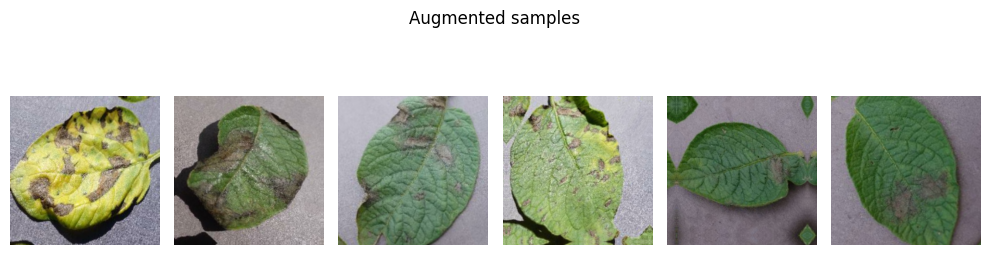

In [ ]:
for xb, yb in train_ds.take(1):
    fig = plt.figure(figsize=(10,3))
    for i in range(6):
        ax = plt.subplot(1,6,i+1)
        aug_img = augment(xb, training=True)[i].numpy().astype("uint8")
        plt.imshow(aug_img)
        plt.axis("off")
    plt.suptitle("Augmented samples")
    plt.tight_layout()
    plt.show()
    break

#### Build the CNN Model

**Layers:**
1. Resize & rescale.
2. Multiple Conv2D + MaxPooling2D layers (feature extraction).
3. Flatten → Dense layers for classification.
4. Dropout for regularization.
5. Output layer with `softmax` activation.

**Why:**  
This is a **baseline CNN** to classify potato diseases.





In [ ]:
def build_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), n_classes=3):
    model = models.Sequential([
        resize_rescale,
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn(n_classes=n_classes)


#### Model Summary

Displays all layers, their output shapes, and trainable parameters.

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_rescale (Sequential)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

####  Compile Model

**Optimizer:** Adam  
**Loss:** Sparse categorical crossentropy (for integer labels).  
**Metric:** Accuracy.

**Why:**  
This setup is standard for multi-class classification.

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



####  Define Callbacks

**Callbacks:**
- `EarlyStopping`: Stops training if validation accuracy stops improving.
- `ReduceLROnPlateau`: Lowers learning rate if loss plateaus.
- `ModelCheckpoint`: Saves the best model.

**Why:**  
Avoids overfitting and reduces wasted training time.

In [ ]:
ckpt_dir = "/content/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
    ModelCheckpoint(filepath=os.path.join(ckpt_dir, "best_cnn.keras"),
                    save_best_only=True, monitor="val_accuracy")
]

#### Train the CNN

- Use augmented training set.
- Validation set to monitor overfitting.
- Pass `class_weights` for imbalance handling.

**Goal:**  
Find best weights that minimize loss & maximize accuracy.

In [ ]:
history_cnn = cnn_model.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.3679 - loss: 1.0677 - val_accuracy: 0.5938 - val_loss: 0.7329 - learning_rate: 0.0010
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.6837 - loss: 0.5799 - val_accuracy: 0.7396 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.8442 - loss: 0.3487 - val_accuracy: 0.8906 - val_loss: 0.3444 - learning_rate: 0.0010
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.8583 - loss: 0.3292 - val_accuracy: 0.7240 - val_loss: 0.8363 - learning_rate: 0.0010
Epoch 5/10


####Visualize Training and Validation Performance


**Plots:**
- Accuracy over epochs.
- Loss over epochs.

**Why:**  
To check if model converged or overfitted.

In [ ]:
def plot_history(h, title="Training Curves"):
    acc = h.history.get('accuracy', [])
    val_acc = h.history.get('val_accuracy', [])
    loss = h.history.get('loss', [])
    val_loss = h.history.get('val_loss', [])
    epochs_ = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_, acc, label='Train Acc')
    plt.plot(epochs_, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_, loss, label='Train Loss')
    plt.plot(epochs_, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_history(history_cnn, title="Baseline CNN")

####  Final Model Evaluation

- Test set accuracy & loss.
- Ensures model generalizes to unseen data.

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

In [ ]:
y_true, y_pred = [], []
for xb, yb in test_ds:
    preds = cnn_model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print("Shapes:", y_true.shape, y_pred.shape)

####  Generate Predictions and Confusion Matrix

**Steps:**
1. Predict on test set.
2. Compare predictions with actual labels.
3. Plot confusion matrix with class names.

**Why:**  
To see which classes the model confuses most.

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

####  Detailed Classification Report

Outputs:
- Precision
- Recall
- F1-score for each class.

**Why:**  
Gives a detailed breakdown of model performance.

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

####  Show Sample Predictions


Displays:
- Test images.
- Predicted vs actual class.
- Prediction confidence.

**Why:**  
Visual confirmation of model performance.

In [ ]:
def show_predictions(model, ds, k=9):
    shown = 0
    plt.figure(figsize=(10,10))
    for xb, yb in ds.take(1):
        preds = model.predict(xb, verbose=0)
        for i in range(min(k, xb.shape[0])):
            ax = plt.subplot(3,3,i+1)
            img = xb[i].numpy().astype("uint8")
            pred = class_names[np.argmax(preds[i])]
            true = class_names[int(yb[i])]
            conf = float(np.max(preds[i]))*100
            plt.imshow(img)
            plt.title(f"T:{true}\nP:{pred} ({conf:.1f}%)")
            plt.axis("off")
            shown += 1
            if shown >= k: break
    plt.tight_layout(); plt.show()

show_predictions(cnn_model, test_ds, k=9)

####  Predict on a Single Image

**Steps:**
- Load random potato leaf image from dataset.
- Preprocess.
- Predict.
- Show probability distribution.

**Why:**  
To test model inference pipeline.

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

plt.show()

In [ ]:

from tensorflow.keras.utils import load_img, img_to_array
img_path = os.path.join(MERGED_DIR, class_names[0], random.choice(os.listdir(os.path.join(MERGED_DIR, class_names[0]))))
img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(img)
plt.axis("off")
img_array = img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)
print("Predicted class:", class_names[np.argmax(pred)])


In [ ]:
plt.bar(class_names, pred[0])
plt.xticks(rotation=20)
plt.ylabel("Probability")
plt.show()

####  Save Model in Multiple Formats

Formats:
- `.keras` (recommended).
- `.h5` (legacy).
- TensorFlow SavedModel format.

**Why:**  
So we can load/reuse the trained model later.

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../potatoes.h5")

####  Validate Loaded Model


- Evaluate on validation set.
- Make predictions on a sample image.

**Why:**  
Ensures loading did not break the model.

In [ ]:
val_loss, val_acc = loaded_model.evaluate(val_ds)
print(f"Validation Accuracy (loaded model): {val_acc:.2f}")

In [ ]:
preds = loaded_model.predict(img_array)
print("Prediction from loaded model:", class_names[np.argmax(preds)])

#### Test on External Image

- Download a potato leaf image from the internet.
- Save as `test_potato.jpg`.

In [ ]:
import requests
url = "https://upload.wikimedia.org/wikipedia/commons/6/64/PotatoLateBlight.jpg"
r = requests.get(url, stream=True)
with open("/content/test_potato.jpg", 'wb') as f:
    shutil.copyfileobj(r.raw, f)
print("✅ Test image downloaded")

#### Check Model Size


- Report file size in MB.
- Useful for deployment planning.

In [ ]:
size_mb = os.path.getsize(MODEL_PATH) / (1024*1024)
print(f"Model size: {size_mb:.2f} MB")

####Cleanup

- Remove large files/folders to save Colab space.

In [ ]:
shutil.rmtree(MODEL_DIR, ignore_errors=True)
print("✅ Cleanup done")